In [ ]:
pip install torch torchvision Pillow

In [ ]:
!wget http://images.cocodataset.org/zips/val2017.zip -O coco_val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O coco_ann2017.zip


--2024-05-06 00:20:35--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.231.73, 3.5.28.156, 3.5.25.228, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.231.73|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘coco_val2017.zip’

coco_val2017.zip    100%[===================>] 777.80M  59.5MB/s    in 14s     

2024-05-06 00:20:48 (57.5 MB/s) - ‘coco_val2017.zip’ saved [815585330/815585330]

--2024-05-06 00:20:48--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.28.117, 16.182.36.145, 52.217.117.193, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.28.117|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘coco_ann2017.zip’

coco_ann2017.zip    100%[=====

In [4]:
from zipfile import ZipFile, BadZipFile
import os
def extract_zip_file(extract_path):
    try:
        with ZipFile(extract_path+".zip") as zfile:
            zfile.extractall(extract_path)
        # remove zipfile
        zfileTOremove=f"{extract_path}"+".zip"
        if os.path.isfile(zfileTOremove):
            os.remove(zfileTOremove)
        else:
            print("Error: %s file not found" % zfileTOremove)
    except BadZipFile as e:
        print("Error:", e)

#extract_val_path = "Downloads/coco_val2017"
extract_ann_path= "Download/coco_ann2017"

#extract_zip_file(extract_val_path)
extract_zip_file(extract_ann_path)

FileNotFoundError: [Errno 2] No such file or directory: 'Download/coco_ann2017.zip'

# Start

In [1]:
import torch
print(torch.cuda.is_available())

True


In [2]:
import torchvision.transforms as transforms
from torchvision.datasets import CocoDetection

# Define the path to your images and annotations
img_folder = 'Downloads/coco_val2017/val2017'
ann_file = 'Downloads/coco_ann2017/annotations/instances_val2017.json'

# Define your transformations
# Note: You might want to modify these transforms depending on your model's requirements
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [3]:
import torchvision.transforms.functional as F

class CocoCars(CocoDetection):
    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        annotations = target
        boxes = []
        labels = []

        for ann in annotations:
            bbox = ann['bbox']
            # Convert COCO bbox from [x, y, width, height] to [xmin, ymin, xmax, ymax]
            bbox = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
            boxes.append(bbox)
            labels.append(1)  # Set label as 1 for cars

        if len(boxes) == 0:
            # Return an empty tensor for boxes and labels
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        return img, target



In [ ]:
coco_dataset = CocoCars(root=img_folder, annFile=ann_file, transform=transform)

In [5]:
import numpy as np
from torch.utils.data import DataLoader, Subset

# Shuffle the indices
indices = torch.randperm(len(coco_dataset)).tolist()

# Split into training and validation sets (90% training, 10% validation)
split = int(len(indices) * 0.9)
train_indices = indices[:split]
val_indices = indices[split:]

train_dataset = Subset(coco_dataset, train_indices)
val_dataset = Subset(coco_dataset, val_indices)


In [6]:
def collate_fn(batch):
    return tuple(zip(*batch))

# DataLoader for the COCO dataset
# data_loader = DataLoader(coco_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
data_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_data_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)


# training

In [4]:
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
# Load the COCO dataset filtered for cars


# Load a pre-trained Faster R-CNN model
def get_model(num_classes):
    # Load a pre-trained Faster R-CNN model
    model = fasterrcnn_resnet50_fpn(pretrained=True)

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one suitable for your number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# We have only one class (car)
model = get_model(num_classes=2)  # Including background

# Define device and move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

loading annotations into memory...
Done (t=0.72s)
creating index...
index created!


C:\Users\ywwei\anaconda3\envs\hw3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ywwei\anaconda3\envs\hw3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [7]:
import torch.optim as optim

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler which decreases the learning rate by 10x every 3 epochs
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


In [8]:
# Number of epochs
num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    i = 0
    epoch_loss = 0

    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        # Ensure targets are in the correct format
        targets_converted = []
        for t in targets:
            if isinstance(t, dict):  # Check if it is already in the right format
                targets_converted.append({k: v.to(device) for k, v in t.items()})
            else:
                # Convert each element in the list to the correct device and format
                converted = {k: torch.stack([d[k] for d in t]).to(device) for k in t[0]}
                targets_converted.append(converted)

        # Calculate the model loss
        loss_dict = model(images, targets_converted)

        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if i % 50 == 0:
            print(f"Iteration #{i} loss: {losses.item()}")
        i += 1

    # Update the learning rate
    lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {epoch_loss / len(data_loader)}")


C:\Users\ywwei\anaconda3\envs\hw3\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Iteration #0 loss: 1.0924538373947144
Iteration #50 loss: 0.4565121531486511
Iteration #100 loss: 0.8459817171096802
Iteration #150 loss: 0.23983615636825562
Iteration #200 loss: 0.41543063521385193
Iteration #250 loss: 0.7137603163719177
Iteration #300 loss: 0.7196573615074158
Iteration #350 loss: 0.30088672041893005
Iteration #400 loss: 0.8117578029632568
Iteration #450 loss: 0.3372902572154999
Iteration #500 loss: 1.1018524169921875
Iteration #550 loss: 0.8164980411529541
Iteration #600 loss: 0.5469658374786377
Iteration #650 loss: 1.1224775314331055
Iteration #700 loss: 0.5062401294708252
Iteration #750 loss: 0.9929792881011963
Iteration #800 loss: 0.4389610290527344
Iteration #850 loss: 0.8740266561508179
Iteration #900 loss: 0.5812085270881653
Iteration #950 loss: 0.6734908819198608
Iteration #1000 loss: 0.5935443639755249
Iteration #1050 loss: 0.5260056853294373
Iteration #1100 loss: 1.020589828491211
Epoch #0 loss: 0.623656891975138


In [9]:
torch.save(model.state_dict(), 'faster_rcnn_car_detector.pth')


In [14]:
from torchvision.ops import box_iou
import numpy as np

def evaluate(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    detections = []
    ground_truths = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = [image.to(device) for image in images]
            outputs = model(images)

            for i, output in enumerate(outputs):
                # Move predictions and targets to CPU
                pred_boxes = output['boxes'].cpu()
                pred_labels = output['labels'].cpu()
                pred_scores = output['scores'].cpu()

                true_boxes = targets[i]['boxes'].cpu()
                true_labels = targets[i]['labels'].cpu()

                # Store predictions and targets for evaluation
                detections.append({
                    'boxes': pred_boxes,
                    'labels': pred_labels,
                    'scores': pred_scores
                })

                ground_truths.append({
                    'boxes': true_boxes,
                    'labels': true_labels
                })

    # Calculate average precision for each class
    average_precisions = calculate_average_precision(detections, ground_truths)

    # Calculate mean average precision (mAP)
    mean_ap = np.mean(list(average_precisions.values()))
    return mean_ap, average_precisions



def calculate_average_precision(detections, ground_truths):
    iou_threshold = 0.5
    average_precisions = {}
    
    for label in range(1, 2):  # Assuming label '1' for cars
        true_positives = []
        scores = []
        num_ground_truths = 0
        
        for detection, ground_truth in zip(detections, ground_truths):
            ground_truth_mask = ground_truth['labels'] == label
            detection_mask = detection['labels'] == label
            
            num_ground_truths += int(torch.sum(ground_truth_mask))
            scores.extend(detection['scores'][detection_mask].tolist())
            
            if not detection_mask.any():
                continue

            detected = torch.zeros(sum(ground_truth_mask), dtype=torch.int)
            for bbox in detection['boxes'][detection_mask]:
                if ground_truth_mask.any():
                    ious = box_iou(ground_truth['boxes'][ground_truth_mask], bbox.unsqueeze(0))
                    if ious.numel() > 0:
                        max_iou, max_index = ious.squeeze(0).max(0)
                        if max_iou >= iou_threshold and detected[max_index] == 0:
                            detected[max_index] = 1
                            true_positives.append(1)
                        else:
                            true_positives.append(0)
                else:
                    true_positives.append(0)

        # Sort by scores
        scores = torch.tensor(scores)
        sorted_indices = torch.argsort(scores, descending=True)
        true_positives = torch.tensor(true_positives)[sorted_indices]
        cumulatives = torch.cumsum(true_positives, dim=0)
        precision = cumulatives.float() / (torch.arange(len(true_positives)) + 1).float()
        recall = cumulatives.float() / num_ground_truths
        # Calculate AP using the trapz method in torch
        ap = torch.trapz(precision, recall)
        average_precisions[label] = ap.item() if num_ground_truths > 0 else 0

    return average_precisions


In [15]:
mean_ap, ap_by_class = evaluate(model, val_data_loader, device)
print(f"Mean Average Precision: {mean_ap}")
print(f"AP by Class: {ap_by_class}")

Mean Average Precision: 0.5209490060806274
AP by Class: {1: 0.5209490060806274}


In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def show_detections(images, targets, model, device, num_images=9):
    model.eval()  # Set the model to evaluation mode
    images = [img.to(device) for img in images]
    predictions = model(images)  # Get model predictions
    
    # Ensure we do not exceed the number of images in the batch
    num_images = min(num_images, len(images))

    for i in range(num_images):
        fig, ax = plt.subplots(1)
        img = images[i].cpu().data.numpy().transpose((1, 2, 0))
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
        img = np.clip(img, 0, 1)
        ax.imshow(img)

        pred_boxes = predictions[i]['boxes'].cpu().data.numpy()
        pred_scores = predictions[i]['scores'].cpu().data.numpy()

        for box, score in zip(pred_boxes, pred_scores):
            if score > 0.5:  # Threshold can be adjusted
                x, y, xmax, ymax = box
                rect = patches.Rectangle((x, y), xmax - x, ymax - y, linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(x, y, f"{score:.2f}", color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

        plt.show()


In [22]:
# Example to test what val_data_loader yields
images, targets = next(iter(val_data_loader))
print(f"Number of images in batch: {len(images)}")


Number of images in batch: 1


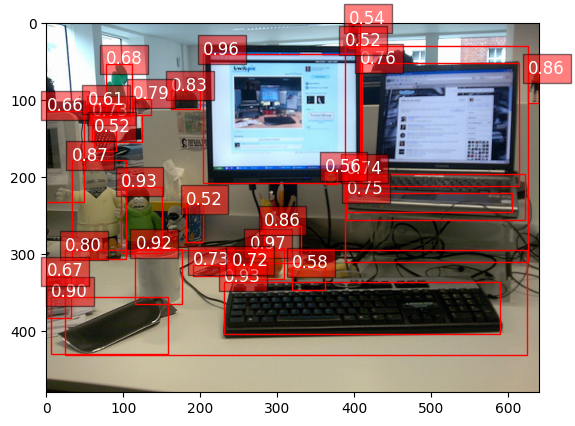

In [23]:
images, targets = next(iter(val_data_loader))
if len(images) > 0:
    show_detections(images, targets, model, device, num_images=9)
else:
    print("No images to display.")
